# Convolutional LSTM

In [65]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load data

In [101]:
parent_path = "../predata"
data_paths = os.listdir(parent_path)

In [102]:
data_paths

['1_0_Lounge_iphone7_10002',
 '1_0_Lounge_Iphone7_20028',
 '1_0_Lounge_Iphone7_20029',
 '1_0_Lounge_Iphone7_20030',
 '1_0_Lounge_Iphone7_20032',
 '1_0_Lounge_Iphone7_20033',
 '2_0_Lounge_Iphone7_20014',
 '2_0_Lounge_Iphone7_20015',
 '2_0_Lounge_Iphone7_20016',
 '2_0_Lounge_Iphone7_20019',
 '3_0_Lounge_HONOR7iAndroid_00024',
 '3_0_Lounge_HONOR7iAndroid_00027',
 '3_0_Lounge_iphone7_10003',
 '3_0_Lounge_iphone7_10006',
 '4_0_Lounge_HONOR7iAndroid_00029',
 '4_0_Lounge_iphone7_10006',
 '4_0_Lounge_Iphone7_20001']

In [103]:
train_set = []
time_length = 10
width,height = 64, 64
for path in data_paths:
    data = np.zeros((time_length,width,height))
    label = int(path[0]) - 1
    stage_name = "stage" + path[0] + "_"
    for i in range(time_length):
        file_name = stage_name + str(i).zfill(4) + ".png"
        file_path = os.path.join(parent_path, path, file_name)
        print(file_path)
        img = cv2.imread(file_path)[:,:,0]
        img = cv2.resize(img, (width, height))
        # normalize image
        data[i,:,:] = (img-np.mean(img))/np.std(img)
    
    train_set.append((np.expand_dims(data, axis=3), label))

../predata\1_0_Lounge_iphone7_10002\stage1_0000.png
../predata\1_0_Lounge_iphone7_10002\stage1_0001.png
../predata\1_0_Lounge_iphone7_10002\stage1_0002.png
../predata\1_0_Lounge_iphone7_10002\stage1_0003.png
../predata\1_0_Lounge_iphone7_10002\stage1_0004.png
../predata\1_0_Lounge_iphone7_10002\stage1_0005.png
../predata\1_0_Lounge_iphone7_10002\stage1_0006.png
../predata\1_0_Lounge_iphone7_10002\stage1_0007.png
../predata\1_0_Lounge_iphone7_10002\stage1_0008.png
../predata\1_0_Lounge_iphone7_10002\stage1_0009.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0000.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0001.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0002.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0003.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0004.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0005.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0006.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0007.png
../predata\1_0_Lounge_Iphone7_20028\stage1_0008.png
../predata\1

In [113]:
random.shuffle(train_set)
tmp = [x[1] for x in train_set]
print(tmp)

[0, 2, 1, 0, 2, 0, 1, 0, 1, 3, 3, 0, 2, 2, 0, 1, 3]


label of 10 th sample: 2


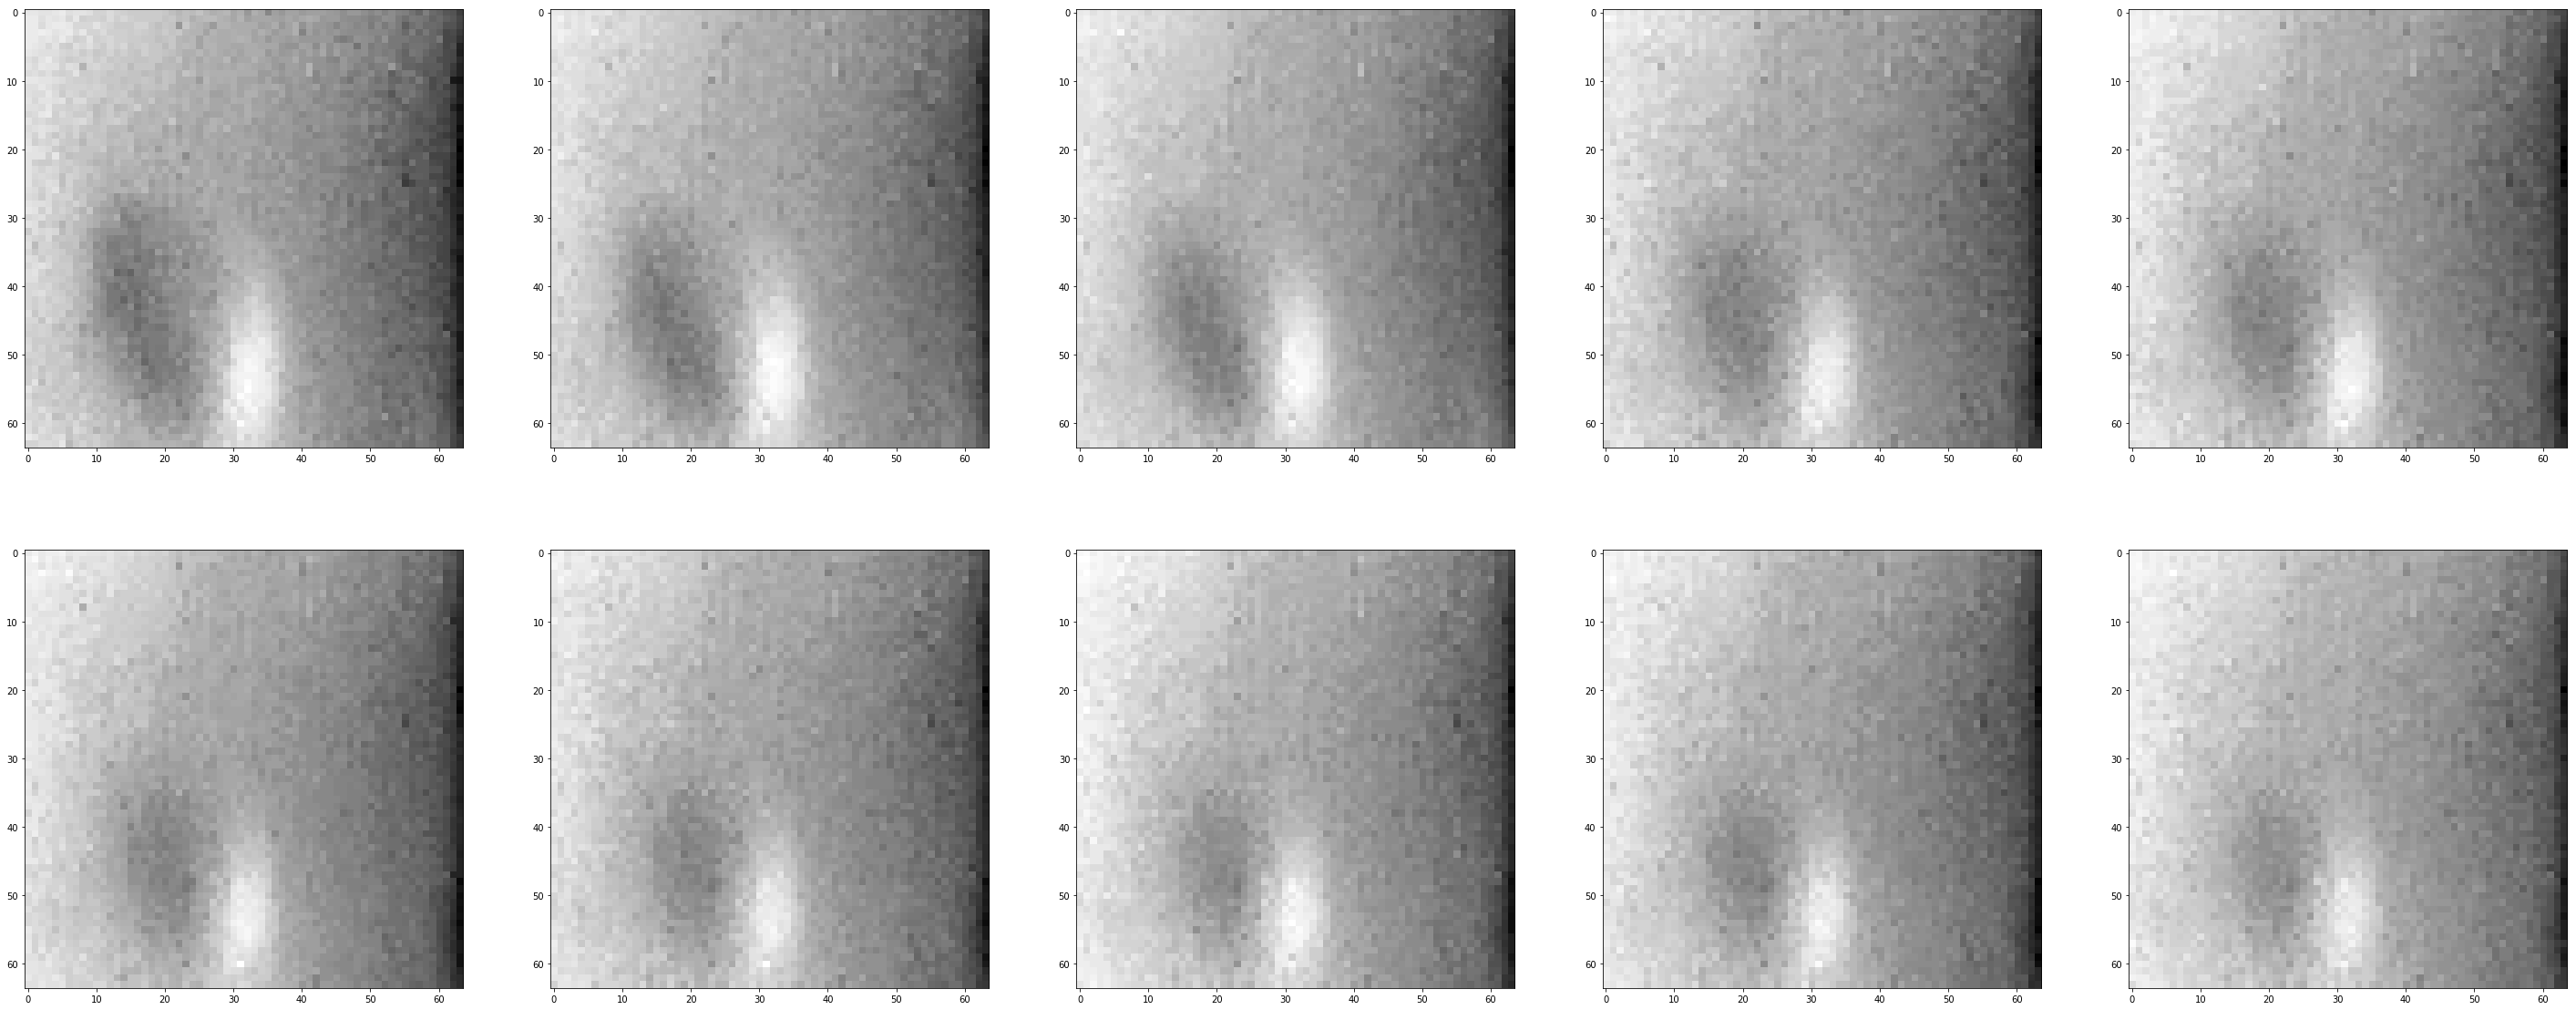

In [105]:
# show training sample
total_step = time_length
idx =10
print("label of {} th sample: {}".format(idx, train_set[idx][1]) )
f, axarr = plt.subplots(2,5, figsize=(50,20))
for step in range(total_step):
    axarr[step//5][step%5].imshow(np.squeeze(train_set[idx][0][step,:,:,:]), cmap="gray")

### build lstm

In [80]:
# clear tf graph
tf.reset_default_graph()

time_length = 10
width, height, channels = 64, 64, 1
# make placeholders for data we'll feed in
imgs = tf.placeholder(tf.float32, [None, time_length, width, height, channels])
labels = tf.placeholder(tf.int32, [None])

# define convolution layer
kernel_shape, in_channel, out_channel = 5, 1, 8
with tf.variable_scope('conv_kernel'):
    w_shape = [kernel_shape, kernel_shape, in_channel, out_channel]
    conv_w = tf.get_variable(name='conv_kernel', shape=w_shape,
                             initializer=tf.glorot_uniform_initializer(seed=1234))
conv_out = []
for t in range(time_length):
    tmp = tf.nn.conv2d(imgs[:,t,:,:,:], conv_w, strides=[1, 4, 4, 1], padding="SAME")
    tmp_flatten = tf.contrib.layers.flatten(tmp)
    conv_out.append(tmp_flatten)
conv_out = tf.stack(conv_out, axis=1)

    
# define the lstm cell
hidden_size = 200
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
batch_size = 2
init_state = lstm_cell.zero_state(batch_size, tf.float32)
lstm_outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, conv_out, initial_state=init_state, dtype=tf.float32)

# output dense layer
stage_num = 4
out = tf.contrib.layers.fully_connected(final_state[-1], stage_num, activation_fn=None)
# loss function
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=out)
loss_mean = tf.reduce_mean(loss)
# optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss_mean)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

### train network

In [114]:
# set training parameters
num_steps = 1000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # get data for a batch
        batch_data = random.sample(train_set[:-2], 2)
        batch_imgs = []
        batch_labels = []
        for i in range(batch_size):
            batch_imgs.append(batch_data[i][0])
            batch_labels.append(batch_data[i][1])
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_labels = np.stack(batch_labels, axis=0)

        # run the 'optimizer', 'loss', and 'pred_err' operations in the graph
        _, train_loss, train_loss_mean, train_out = sess.run(
            [optimizer, loss, loss_mean, out], feed_dict={imgs: batch_imgs, labels: batch_labels})

        # print stuff every 50 steps to see how we are doing
        if (step % 1 == 0):
            #pass
            print("Minibatch train out at step {}: {}".format(step, train_out))
            print("Minibatch train loss at step {}: {}".format(step, train_loss))
            print("Minibatch train loss mean at step {}: {}".format(step, train_loss_mean))
            print("Minibatch train prediction at step {}: {}".format(step, np.argmax(train_out, axis=1)))
            print("Ground truth at step {}: {}".format(step, batch_labels, axis=1))
            print("*"*100)
            
    # test accuracy
    num_correct = 0
    test_set = train_set[-2:]
    for k in range(len(test_set)//batch_size):
        batch_data = test_set[k:k+2]
        batch_imgs = []
        batch_labels = []
        for i in range(batch_size):
            batch_imgs.append(batch_data[i][0])
            batch_labels.append(batch_data[i][1])
        batch_imgs = np.stack(batch_imgs, axis=0)
        batch_labels = np.stack(batch_labels, axis=0)

        # run the 'optimizer', 'loss', and 'pred_err' operations in the graph
        test_out = sess.run(out, feed_dict={imgs: batch_imgs})
        num_correct += np.sum(np.argmax(test_out, axis=1) == batch_labels)
        
    print("test acc: {}".format(num_correct/len(test_set)))

Minibatch train out at step 0: [[-0.23040813  0.2235131   0.38369185  0.22390381]
 [-0.15495509  0.98969078  0.10728611  0.10541344]]
Minibatch train loss at step 0: [ 1.17725205  0.76320291]
Minibatch train loss mean at step 0: 0.9702274799346924
Minibatch train prediction at step 0: [2 1]
Ground truth at step 0: [2 1]
****************************************************************************************************
Minibatch train out at step 1: [[-1.17549336  3.47151065  1.5872581  -1.61407721]
 [ 0.23965044  0.2550658   0.92317051 -0.2041602 ]]
Minibatch train loss at step 1: [ 0.15505156  1.53427458]
Minibatch train loss mean at step 1: 0.8446630835533142
Minibatch train prediction at step 1: [1 2]
Ground truth at step 1: [1 0]
****************************************************************************************************
Minibatch train out at step 2: [[-1.74270403  5.65132189  0.60440838 -2.19483519]
 [ 0.68301594 -1.36912405  1.80986071 -0.94416857]]
Minibatch train loss

Minibatch train out at step 24: [[ 3.08271408  1.63157713 -0.48852447 -0.11009713]
 [ 1.88195801  3.4490037  -0.35141492 -0.50553608]]
Minibatch train loss at step 24: [ 0.26503837  0.22329527]
Minibatch train loss mean at step 24: 0.24416682124137878
Minibatch train prediction at step 24: [0 1]
Ground truth at step 24: [0 1]
****************************************************************************************************
Minibatch train out at step 25: [[ 0.19188002 -0.15188412  0.37970987  1.92430842]
 [ 1.57253933  4.09455204 -0.47412646 -0.70075017]]
Minibatch train loss at step 25: [ 0.41585016  0.09434425]
Minibatch train loss mean at step 25: 0.2550972104072571
Minibatch train prediction at step 25: [3 1]
Ground truth at step 25: [3 1]
****************************************************************************************************
Minibatch train out at step 26: [[-2.13083816 -2.63221169  4.74457884 -0.58862185]
 [ 1.50846398  4.2251749  -0.51990253 -0.7013064 ]]
Minibatc

Minibatch train out at step 48: [[ 5.97639275 -1.85417283 -2.1632812   0.10147496]
 [ 1.99570847  4.79168844 -1.09401584 -0.67337799]]
Minibatch train loss at step 48: [ 0.00349209  0.06584954]
Minibatch train loss mean at step 48: 0.034670814871788025
Minibatch train prediction at step 48: [0 1]
Ground truth at step 48: [0 1]
****************************************************************************************************
Minibatch train out at step 49: [[-1.43187749 -2.78044915  3.77378249 -0.11442173]
 [ 6.40065718 -1.3691237  -2.41020894 -1.09990919]]
Minibatch train loss at step 49: [ 0.02702312  0.00112363]
Minibatch train loss mean at step 49: 0.014073374681174755
Minibatch train prediction at step 49: [2 0]
Ground truth at step 49: [2 0]
****************************************************************************************************
Minibatch train out at step 50: [[ 4.8664341   1.02256095 -1.18570554 -0.25966394]
 [ 4.90246105  0.96159917 -1.26351297 -0.34996083]]
Minib

Minibatch train out at step 72: [[-0.02230977 -0.74664724 -0.08839084  4.50178576]
 [ 4.73838091  1.65760767 -1.56216538 -0.53836924]]
Minibatch train loss at step 72: [ 0.02591266  0.05151788]
Minibatch train loss mean at step 72: 0.03871527314186096
Minibatch train prediction at step 72: [3 0]
Ground truth at step 72: [3 0]
****************************************************************************************************
Minibatch train out at step 73: [[ 6.21920395 -1.85685682 -2.15769815 -0.07197788]
 [ 5.07935524 -2.00388026 -1.81122231 -0.6540485 ]]
Minibatch train loss at step 73: [ 0.00239062  0.00507946]
Minibatch train loss mean at step 73: 0.0037350421771407127
Minibatch train prediction at step 73: [0 0]
Ground truth at step 73: [0 0]
****************************************************************************************************
Minibatch train out at step 74: [[ 5.29229403  1.14442444 -1.50369895 -0.5598489 ]
 [ 1.33629525  5.07916307 -1.07863963 -0.80263489]]
Minib

Minibatch train loss at step 95: [ 0.00121293  0.0051167 ]
Minibatch train loss mean at step 95: 0.003164817811921239
Minibatch train prediction at step 95: [2 2]
Ground truth at step 95: [2 2]
****************************************************************************************************
Minibatch train out at step 96: [[ 1.32523119  6.03927803 -1.305691   -0.955836  ]
 [ 6.39482832 -1.86427283 -2.14310741 -0.178055  ]]
Minibatch train loss at step 96: [ 0.01047553  0.0018508 ]
Minibatch train loss mean at step 96: 0.006163164507597685
Minibatch train prediction at step 96: [1 0]
Ground truth at step 96: [1 0]
****************************************************************************************************
Minibatch train out at step 97: [[-2.04771996 -1.97255063  5.49524307 -1.8767904 ]
 [-0.09340362 -0.8987813  -0.09504595  4.90903568]]
Minibatch train loss at step 97: [ 0.00172811  0.01630237]
Minibatch train loss mean at step 97: 0.00901524256914854
Minibatch train predict

Minibatch train out at step 120: [[ 1.22969365  6.14677763 -1.32584071 -1.1465646 ]
 [ 6.53473234 -1.87405443 -2.11072755 -0.29546681]]
Minibatch train loss at step 120: [ 0.00853238  0.00147841]
Minibatch train loss mean at step 120: 0.005005395971238613
Minibatch train prediction at step 120: [1 0]
Ground truth at step 120: [1 0]
****************************************************************************************************
Minibatch train out at step 121: [[-2.23965287 -2.82472062  4.89021826 -0.22872967]
 [ 5.9468112   0.66289818 -1.79432738 -0.94550252]]
Minibatch train loss at step 121: [ 0.0072032   0.00650147]
Minibatch train loss mean at step 121: 0.006852339021861553
Minibatch train prediction at step 121: [2 0]
Ground truth at step 121: [2 0]
****************************************************************************************************
Minibatch train out at step 122: [[ 6.54742908 -1.87254786 -2.10689902 -0.30978024]
 [-2.4908824  -2.802176    5.94840384 -1.54650

Minibatch train out at step 144: [[ 6.20125961  0.5163756  -1.86540794 -1.05225158]
 [-2.31542945 -2.8598423   5.08995485 -0.3839249 ]]
Minibatch train loss at step 144: [ 0.00440864  0.00514244]
Minibatch train loss mean at step 144: 0.004775539040565491
Minibatch train prediction at step 144: [0 2]
Ground truth at step 144: [0 2]
****************************************************************************************************
Minibatch train out at step 145: [[ 0.31865615  6.19320774 -0.94896048 -1.25864065]
 [ 6.29738331  0.57223028 -1.79209268 -1.00448608]]
Minibatch train loss at step 145: [ 0.00417267  0.00423487]
Minibatch train loss mean at step 145: 0.004203769378364086
Minibatch train prediction at step 145: [1 0]
Ground truth at step 145: [1 0]
****************************************************************************************************
Minibatch train out at step 146: [[-0.13974807 -1.08919108 -0.22084755  5.67207289]
 [ 0.63792926  6.09414196 -1.10406911 -1.23047

Minibatch train out at step 168: [[-0.85406351 -3.62368941 -0.00978522  5.65545368]
 [-0.16447604 -1.11561024 -0.23252474  5.84347248]]
Minibatch train loss at step 168: [ 0.00503415  0.00569021]
Minibatch train loss mean at step 168: 0.00536218099296093
Minibatch train prediction at step 168: [3 3]
Ground truth at step 168: [3 3]
****************************************************************************************************
Minibatch train out at step 169: [[ 6.12432241  0.83164507 -2.04200196 -1.15548372]
 [ 6.41365719  0.38024947 -1.93557847 -1.12319493]]
Minibatch train loss at step 169: [ 0.00598365  0.00316203]
Minibatch train loss mean at step 169: 0.004572841338813305
Minibatch train prediction at step 169: [0 0]
Ground truth at step 169: [0 0]
****************************************************************************************************
Minibatch train out at step 170: [[-0.16473846 -1.11901033 -0.23681951  5.86043978]
 [-2.40836692 -2.91485596  5.31504726 -0.535880

Minibatch train out at step 192: [[-2.37104678 -3.03591013  5.70859766 -1.11718524]
 [-0.1768878  -1.14592481 -0.29410079  6.05788088]]
Minibatch train loss at step 192: [ 0.00155328  0.00443724]
Minibatch train loss mean at step 192: 0.0029952628538012505
Minibatch train prediction at step 192: [2 3]
Ground truth at step 192: [2 3]
****************************************************************************************************
Minibatch train out at step 193: [[-0.86639518 -3.62976217 -0.14362431  5.90700579]
 [ 6.57996225  0.26165307 -1.98895741 -1.16643548]]
Minibatch train loss at step 193: [ 0.00356598  0.00242226]
Minibatch train loss mean at step 193: 0.0029941184911876917
Minibatch train prediction at step 193: [3 0]
Ground truth at step 193: [3 0]
****************************************************************************************************
Minibatch train out at step 194: [[ 0.21425039  6.42014456 -0.98412073 -1.33556807]
 [-2.57671547 -2.81738424  6.27087975 -1.756

Minibatch train out at step 214: [[-2.5104003  -2.99737883  5.50946379 -0.58888829]
 [ 6.82456923 -1.58532524 -2.36452508 -1.42456281]]
Minibatch train loss at step 214: [ 0.00277373  0.0005861 ]
Minibatch train loss mean at step 214: 0.0016799127915874124
Minibatch train prediction at step 214: [2 0]
Ground truth at step 214: [2 0]
****************************************************************************************************
Minibatch train out at step 215: [[ 6.84499454 -1.89122069 -2.10068846 -0.52622592]
 [-2.60898566 -2.82177138  6.35276127 -1.807706  ]]
Minibatch train loss at step 215: [ 0.00091963  0.00051747]
Minibatch train loss mean at step 215: 0.0007185535505414009
Minibatch train prediction at step 215: [0 2]
Ground truth at step 215: [0 2]
****************************************************************************************************
Minibatch train out at step 216: [[-0.87125081 -3.63184857 -0.23552474  6.08820629]
 [ 0.17971371  6.51486301 -1.00152707 -1.363

Minibatch train out at step 238: [[-2.65163636 -1.98888445  6.42256975 -1.96503496]
 [ 6.8843236  -1.61069465 -2.36415267 -1.4570502 ]]
Minibatch train loss at step 238: [ 0.00056442  0.00053892]
Minibatch train loss mean at step 238: 0.0005516675300896168
Minibatch train prediction at step 238: [2 0]
Ground truth at step 238: [2 0]
****************************************************************************************************
Minibatch train out at step 239: [[ 6.61441708  0.52469683 -2.13815403 -1.21851599]
 [ 6.89127636 -1.61270177 -2.36447358 -1.4596858 ]]
Minibatch train loss at step 239: [ 0.00281664  0.00053427]
Minibatch train loss mean at step 239: 0.0016754565294831991
Minibatch train prediction at step 239: [0 0]
Ground truth at step 239: [0 0]
****************************************************************************************************
Minibatch train out at step 240: [[ 0.33648694  6.53686285 -1.1936121  -1.29543352]
 [ 6.82739449  0.1135366  -2.04923129 -1.205

Minibatch train out at step 262: [[-0.88382393 -3.63555384 -0.28225401  6.2294631 ]
 [ 6.99226141 -1.64843166 -2.36918449 -1.50092292]]
Minibatch train loss at step 262: [ 0.00234936  0.00046743]
Minibatch train loss mean at step 262: 0.0014083931455388665
Minibatch train prediction at step 262: [3 0]
Ground truth at step 262: [3 0]
****************************************************************************************************
Minibatch train out at step 263: [[ 0.30099845  6.62070465 -1.20138216 -1.31651676]
 [ 7.04131699  0.11126721 -2.01799893 -1.29149473]]
Minibatch train loss at step 263: [ 0.00255508  0.0013339 ]
Minibatch train loss mean at step 263: 0.001944490009918809
Minibatch train prediction at step 263: [1 0]
Ground truth at step 263: [1 0]
****************************************************************************************************
Minibatch train out at step 264: [[-2.66795564 -2.83454537  6.53933716 -1.93587327]
 [ 6.74758005  0.44243515 -2.15125608 -1.2372

Minibatch train out at step 287: [[ 7.05284119 -1.67385256 -2.37371659 -1.53059959]
 [ 0.21794353  6.76624107 -1.20841479 -1.33242798]]
Minibatch train loss at step 287: [ 0.0004299  0.0020784]
Minibatch train loss mean at step 287: 0.0012541469186544418
Minibatch train prediction at step 287: [0 1]
Ground truth at step 287: [0 1]
****************************************************************************************************
Minibatch train out at step 288: [[-2.70747805 -1.99987888  6.57160378 -2.01678443]
 [ 6.83137512  0.41400585 -2.17606044 -1.26433372]]
Minibatch train loss at step 288: [ 0.00046886  0.00205817]
Minibatch train loss mean at step 288: 0.00126351707149297
Minibatch train prediction at step 288: [2 0]
Ground truth at step 288: [2 0]
****************************************************************************************************
Minibatch train out at step 289: [[ 0.52444726  6.87134361 -1.308038   -1.55671322]
 [ 7.12661362 -1.86872983 -2.04647374 -0.8178963

Minibatch train out at step 311: [[ 7.21906137  0.02136426 -2.05149293 -1.33074057]
 [ 6.92626476  0.36110294 -2.19121599 -1.29204381]]
Minibatch train loss at step 311: [ 0.00103551  0.0017863 ]
Minibatch train loss mean at step 311: 0.0014109080657362938
Minibatch train prediction at step 311: [0 0]
Ground truth at step 311: [0 0]
****************************************************************************************************
Minibatch train out at step 312: [[-0.08042802  6.98937368 -1.07444882 -1.43342853]
 [ 7.10908651 -0.04961182 -2.10767746 -1.27161765]]
Minibatch train loss at step 312: [ 0.00138402  0.00110601]
Minibatch train loss mean at step 312: 0.0012450115755200386
Minibatch train prediction at step 312: [1 0]
Ground truth at step 312: [1 0]
****************************************************************************************************
Minibatch train out at step 313: [[ 0.16146201  6.88059998 -1.20997822 -1.34907544]
 [-0.89781791 -3.62768459 -0.33624199  6.366

Minibatch train out at step 334: [[-0.25800106 -1.1879257  -0.50300902  6.76262379]
 [ 6.42643309 -2.48467064 -1.94127142 -1.37776363]]
Minibatch train loss at step 334: [ 0.00194301  0.0007748 ]
Minibatch train loss mean at step 334: 0.001358904642984271
Minibatch train prediction at step 334: [3 0]
Ground truth at step 334: [3 0]
****************************************************************************************************
Minibatch train out at step 335: [[-2.71969318 -2.84853935  6.69784403 -2.02892876]
 [ 7.27615166 -1.86780155 -2.03275084 -0.94854987]]
Minibatch train loss at step 335: [ 0.0003149   0.00046528]
Minibatch train loss mean at step 335: 0.00039009307511150837
Minibatch train prediction at step 335: [2 0]
Ground truth at step 335: [2 0]
****************************************************************************************************
Minibatch train out at step 336: [[ 7.32872629 -0.05642453 -2.0591495  -1.35168374]
 [-2.75341153 -2.00713491  6.68000221 -2.045

Minibatch train out at step 359: [[ 6.51371813 -2.50940585 -1.94549477 -1.42424881]
 [-0.92102426 -3.62061238 -0.36765715  6.46806002]]
Minibatch train loss at step 359: [ 0.00068927  0.00173275]
Minibatch train loss mean at step 359: 0.0012110117822885513
Minibatch train prediction at step 359: [0 3]
Ground truth at step 359: [0 3]
****************************************************************************************************
Minibatch train out at step 360: [[-2.775213   -2.01833606  6.74277782 -2.06461406]
 [-2.62521744 -3.16043806  6.04692793 -0.87203449]]
Minibatch train loss at step 360: [ 0.00037973  0.00125961]
Minibatch train loss mean at step 360: 0.0008196674752980471
Minibatch train prediction at step 360: [2 2]
Ground truth at step 360: [2 2]
****************************************************************************************************
Minibatch train out at step 361: [[ 7.341609   -1.87305164 -2.02451587 -1.00209892]
 [-0.92195827 -3.61909795 -0.37152478  6.476

Minibatch train out at step 383: [[-0.31247017 -1.200261   -0.55577981  6.93837118]
 [ 0.27727866  7.18872929 -1.35979843 -1.60756218]]
Minibatch train loss at step 383: [ 0.00155673  0.00134056]
Minibatch train loss mean at step 383: 0.0014486485160887241
Minibatch train prediction at step 383: [3 1]
Ground truth at step 383: [3 1]
****************************************************************************************************
Minibatch train out at step 384: [[ 7.41236591 -1.87283492 -2.0241344  -1.05414128]
 [-2.65343595 -3.18755531  6.13738108 -0.91338909]]
Minibatch train loss at step 384: [ 0.00038283  0.00110744]
Minibatch train loss mean at step 384: 0.0007451319834217429
Minibatch train prediction at step 384: [0 2]
Ground truth at step 384: [0 2]
****************************************************************************************************
Minibatch train out at step 385: [[-0.92980981 -3.59943032 -0.42098135  6.58260202]
 [-2.51168561 -3.25700641  6.40006685 -1.433

 [ 7.47991467 -1.87358463 -2.02109671 -1.10541189]]
Minibatch train loss at step 407: [ 0.00095239  0.00034815]
Minibatch train loss mean at step 407: 0.0006502679316326976
Minibatch train prediction at step 407: [2 0]
Ground truth at step 407: [2 0]
****************************************************************************************************
Minibatch train out at step 408: [[-0.01212147  7.20915031 -1.22044468 -1.3840071 ]
 [-2.54341006 -3.27718163  6.49126053 -1.47963095]]
Minibatch train loss at step 408: [ 0.00113387  0.00052164]
Minibatch train loss mean at step 408: 0.0008277573506347835
Minibatch train prediction at step 408: [1 2]
Ground truth at step 408: [1 2]
****************************************************************************************************
Minibatch train out at step 409: [[-2.77422619 -2.86837029  6.87733889 -2.1401577 ]
 [-2.6905551  -3.21423221  6.25076056 -0.97581953]]
Minibatch train loss at step 409: [ 0.00024411  0.000935  ]
Minibatch train 

Minibatch train out at step 432: [[ 7.51811504 -0.15110978 -2.11417723 -1.39587867]
 [ 6.82265091 -2.60421348 -1.98681235 -1.54403555]]
Minibatch train loss at step 432: [ 0.00066675  0.00046231]
Minibatch train loss mean at step 432: 0.0005645297933369875
Minibatch train prediction at step 432: [0 0]
Ground truth at step 432: [0 0]
****************************************************************************************************
Minibatch train out at step 433: [[ 7.52097607 -0.15353118 -2.11421323 -1.396294  ]
 [-0.24549915  7.34366608 -1.10248017 -1.49687862]]
Minibatch train loss at step 433: [ 0.00066389  0.00086497]
Minibatch train loss mean at step 433: 0.0007644302677363157
Minibatch train prediction at step 433: [0 1]
Ground truth at step 433: [0 1]
****************************************************************************************************
Minibatch train out at step 434: [[ 7.25219822  0.18025118 -2.27623272 -1.37151921]
 [ 6.83014965 -2.60706735 -1.98833323 -1.545

Minibatch train out at step 456: [[-0.36147261 -1.23236048 -0.63051826  7.16140127]
 [-2.82050347 -2.88342643  7.00609446 -2.21725321]]
Minibatch train loss at step 456: [ 0.00117924  0.00020335]
Minibatch train loss mean at step 456: 0.0006912941462360322
Minibatch train prediction at step 456: [3 2]
Ground truth at step 456: [3 2]
****************************************************************************************************
Minibatch train out at step 457: [[ 6.92324257 -2.64676976 -2.00808072 -1.56921518]
 [-2.83842754 -2.05045724  6.9561286  -2.13905406]]
Minibatch train loss at step 457: [ 0.0004069   0.00029047]
Minibatch train loss mean at step 457: 0.0003486842615529895
Minibatch train prediction at step 457: [0 2]
Ground truth at step 457: [0 2]
****************************************************************************************************
Minibatch train out at step 458: [[ 7.59858799 -0.21392117 -2.1171298  -1.41452873]
 [-2.82204604 -2.8841486   7.00962782 -2.219

Minibatch train out at step 481: [[-0.3863607  -1.24916995 -0.67117     7.27354431]
 [-0.27828634  7.4442277  -1.10704231 -1.52856803]]
Minibatch train loss at step 481: [ 0.0010242   0.00076265]
Minibatch train loss mean at step 481: 0.0008934234501793981
Minibatch train prediction at step 481: [3 1]
Ground truth at step 481: [3 1]
****************************************************************************************************
Minibatch train out at step 482: [[-0.38767588 -1.2495656  -0.67253053  7.27754927]
 [-2.83747125 -2.88927722  7.0480876  -2.2385385 ]]
Minibatch train loss at step 482: [ 0.00101896  0.00019179]
Minibatch train loss mean at step 482: 0.0006053739343769848
Minibatch train prediction at step 482: [3 2]
Ground truth at step 482: [3 2]
****************************************************************************************************
Minibatch train out at step 483: [[-2.83816695 -2.88960266  7.04992676 -2.23951769]
 [ 7.52877712 -1.85101795 -2.43859172 -1.741

Minibatch train out at step 505: [[ 7.46117496  0.03463626 -2.30160856 -1.42355549]
 [-2.85281801 -2.89614463  7.09209394 -2.26292062]]
Minibatch train loss at step 505: [ 0.000791    0.00018047]
Minibatch train loss mean at step 505: 0.0004857324529439211
Minibatch train prediction at step 505: [0 2]
Ground truth at step 505: [0 2]
****************************************************************************************************
Minibatch train out at step 506: [[-0.4120442  -1.25583637 -0.69368744  7.34330273]
 [-0.31716096  7.51432276 -1.11281788 -1.53827691]]
Minibatch train loss at step 506: [ 0.00093559  0.00069308]
Minibatch train loss mean at step 506: 0.000814337283372879
Minibatch train prediction at step 506: [3 1]
Ground truth at step 506: [3 1]
****************************************************************************************************
Minibatch train out at step 507: [[-2.87258077 -2.0826354   7.06281662 -2.15759134]
 [-0.09017477  7.41289377 -1.23753667 -1.4346

 [ 0.06054765  7.54115057 -1.40937722 -1.6805141 ]]
Minibatch train loss at step 529: [ 0.00033707  0.00079207]
Minibatch train loss mean at step 529: 0.0005645686760544777
Minibatch train prediction at step 529: [0 1]
Ground truth at step 529: [0 1]
****************************************************************************************************
Minibatch train out at step 530: [[-2.64966917 -3.36944461  6.75972557 -1.56077147]
 [ 7.70769262 -1.89810503 -2.03660035 -1.24864781]]
Minibatch train loss at step 530: [ 0.00036519  0.00025484]
Minibatch train loss mean at step 530: 0.00031001376919448376
Minibatch train prediction at step 530: [2 0]
Ground truth at step 530: [2 0]
****************************************************************************************************
Minibatch train out at step 531: [[ 7.61093283 -0.34461442 -2.23489451 -1.39803267]
 [-2.65079856 -3.3703208   6.76285791 -1.56245601]]
Minibatch train loss at step 531: [ 0.00052581  0.00036364]
Minibatch train

 [-2.82487178 -3.34093022  6.60229254 -1.09387958]]
Minibatch train loss at step 554: [ 0.00015234  0.00058288]
Minibatch train loss mean at step 554: 0.00036761030787602067
Minibatch train prediction at step 554: [2 2]
Ground truth at step 554: [2 2]
****************************************************************************************************
Minibatch train out at step 555: [[-0.16617492  7.55494213 -1.24913025 -1.46432555]
 [-0.45207566 -1.2709192  -0.72679728  7.46154785]]
Minibatch train loss at step 555: [ 0.00071417  0.00080458]
Minibatch train loss mean at step 555: 0.0007593717891722918
Minibatch train prediction at step 555: [1 3]
Ground truth at step 555: [1 3]
****************************************************************************************************
Minibatch train out at step 556: [[-2.82708883 -3.34290457  6.60805941 -1.09664643]
 [-2.68262672 -3.38878036  6.83466911 -1.59468043]]
Minibatch train loss at step 556: [ 0.00057812  0.00032825]
Minibatch train

 [ 7.81697369 -0.32431564 -2.17054629 -1.47641087]]
Minibatch train loss at step 579: [ 0.00081411  0.00042918]
Minibatch train loss mean at step 579: 0.0006216434412635863
Minibatch train prediction at step 579: [3 0]
Ground truth at step 579: [3 0]
****************************************************************************************************
Minibatch train out at step 580: [[ 7.69692707 -0.4011451  -2.25076389 -1.42231226]
 [ 7.15734005 -2.74676657 -2.05097628 -1.64168358]]
Minibatch train loss at step 580: [ 0.00046135  0.00030108]
Minibatch train loss mean at step 580: 0.0003812150389421731
Minibatch train prediction at step 580: [0 0]
Ground truth at step 580: [0 0]
****************************************************************************************************
Minibatch train out at step 581: [[-0.40836254  7.69412565 -1.12772834 -1.57009649]
 [ 7.82046318 -0.32604888 -2.17104602 -1.4776479 ]]
Minibatch train loss at step 581: [ 0.00054488  0.00042704]
Minibatch train 

 [ 7.63043356 -0.04184508 -2.34279346 -1.46339202]]
Minibatch train loss at step 604: [ 0.00017713  0.00062434]
Minibatch train loss mean at step 604: 0.0004007359384559095
Minibatch train prediction at step 604: [0 0]
Ground truth at step 604: [0 0]
****************************************************************************************************
Minibatch train out at step 605: [[-1.04038274 -3.56075501 -0.54976344  7.16195297]
 [ 7.21535301 -2.76884675 -2.06373572 -1.65591407]]
Minibatch train loss at step 605: [ 0.00074335  0.00027975]
Minibatch train loss mean at step 605: 0.000511548132635653
Minibatch train prediction at step 605: [3 0]
Ground truth at step 605: [3 0]
****************************************************************************************************
Minibatch train out at step 606: [[ 7.84410906 -1.91427076 -2.04788017 -1.33399463]
 [ 7.74126053 -0.42680079 -2.25945163 -1.43583941]]
Minibatch train loss at step 606: [ 0.00021157  0.00043228]
Minibatch train l

Minibatch train out at step 629: [[ 7.89088058 -1.91970098 -2.05274868 -1.36324024]
 [-0.23087458  7.72940683 -1.27059114 -1.52686059]]
Minibatch train loss at step 629: [ 0.00019858  0.00056775]
Minibatch train loss mean at step 629: 0.0003831674112007022
Minibatch train prediction at step 629: [0 1]
Ground truth at step 629: [0 1]
****************************************************************************************************
Minibatch train out at step 630: [[-0.05600791  7.75001144 -1.42031014 -1.72303605]
 [ 7.7351265  -1.92944181 -2.48044372 -1.84236729]]
Minibatch train loss at step 630: [ 0.00058801  0.00016938]
Minibatch train loss mean at step 630: 0.00037869386142119765
Minibatch train prediction at step 630: [1 0]
Ground truth at step 630: [1 0]
****************************************************************************************************
Minibatch train out at step 631: [[ 7.26259565 -2.78520656 -2.0739398  -1.66837895]
 [ 7.78114462 -0.44793609 -2.26952386 -1.44

 [ 7.71367693 -0.07573975 -2.35947704 -1.48182499]]
Minibatch train loss at step 653: [ 0.00018702  0.00055762]
Minibatch train loss mean at step 653: 0.0003723233239725232
Minibatch train prediction at step 653: [0 0]
Ground truth at step 653: [0 0]
****************************************************************************************************
Minibatch train out at step 654: [[-0.2688891   7.82321596 -1.27921164 -1.56291366]
 [ 7.93699169 -1.92575896 -2.05886483 -1.39121819]]
Minibatch train loss at step 654: [ 0.00050103  0.00018655]
Minibatch train loss mean at step 654: 0.0003437877167016268
Minibatch train prediction at step 654: [1 0]
Ground truth at step 654: [1 0]
****************************************************************************************************
Minibatch train out at step 655: [[-2.93504882 -2.16491866  7.35637283 -2.22005939]
 [ 7.93964529 -1.92606187 -2.05905843 -1.39301562]]
Minibatch train loss at step 655: [ 0.00017653  0.00018583]
Minibatch train 

Minibatch train out at step 678: [[-2.9687202  -2.94790936  7.4365325  -2.45958734]
 [-1.07904768 -3.55661678 -0.58177608  7.30878735]]
Minibatch train loss at step 678: [ 0.00011157  0.00062077]
Minibatch train loss mean at step 678: 0.0003661710652522743
Minibatch train prediction at step 678: [2 3]
Ground truth at step 678: [2 3]
****************************************************************************************************
Minibatch train out at step 679: [[ 7.33343935 -2.80779815 -2.08804679 -1.68793833]
 [-1.07982981 -3.55619955 -0.58347738  7.31264925]]
Minibatch train loss at step 679: [ 0.00024113  0.00061755]
Minibatch train loss mean at step 679: 0.0004293415695428848
Minibatch train prediction at step 679: [0 3]
Ground truth at step 679: [0 3]
****************************************************************************************************
Minibatch train out at step 680: [[ 7.33533478 -2.80825114 -2.0886476  -1.68803787]
 [-0.50006306  7.9153285  -1.14753938 -1.628

 [-0.31145996  7.94001675 -1.29278803 -1.60913992]]
Minibatch train loss at step 702: [ 0.00049376  0.00042978]
Minibatch train loss mean at step 702: 0.00046176923206076026
Minibatch train prediction at step 702: [0 1]
Ground truth at step 702: [0 1]
****************************************************************************************************
Minibatch train out at step 703: [[-0.16612518  7.90616846 -1.41520858 -1.72962284]
 [ 8.03250694 -1.93673003 -2.07561755 -1.44720221]]
Minibatch train loss at step 703: [ 0.00046683  0.00016402]
Minibatch train loss mean at step 703: 0.0003154261503368616
Minibatch train prediction at step 703: [1 0]
Ground truth at step 703: [1 0]
****************************************************************************************************
Minibatch train out at step 704: [[-1.10575616 -3.54489946 -0.63680637  7.41868114]
 [-0.52854979  7.97709846 -1.15346885 -1.64433002]]
Minibatch train loss at step 704: [ 0.00053308  0.00037687]
Minibatch train

Minibatch train out at step 727: [[ 7.8213172  -1.97045016 -2.49768996 -1.89620996]
 [-0.19638854  7.94961596 -1.41284859 -1.73001504]]
Minibatch train loss at step 727: [ 0.00014912  0.00043824]
Minibatch train loss mean at step 727: 0.00029367810930125415
Minibatch train prediction at step 727: [0 1]
Ground truth at step 727: [0 1]
****************************************************************************************************
Minibatch train out at step 728: [[ 7.84524632 -0.13943438 -2.37296796 -1.50284827]
 [ 7.44619751 -2.83820844 -2.11981964 -1.70844293]]
Minibatch train loss at step 728: [ 0.00046421  0.00021002]
Minibatch train loss mean at step 728: 0.00033711857395246625
Minibatch train prediction at step 728: [0 0]
Ground truth at step 728: [0 0]
****************************************************************************************************
Minibatch train out at step 729: [[-2.95674324 -2.20461845  7.47224283 -2.22899866]
 [-0.54128206 -1.31025517 -0.79979217  7.7

Minibatch train out at step 751: [[-2.84576082 -3.50236702  7.1779356  -1.70202947]
 [ 8.07886791 -0.45052797 -2.21788359 -1.5405035 ]]
Minibatch train loss at step 751: [ 0.00020645  0.00029762]
Minibatch train loss mean at step 751: 0.0002520352427382022
Minibatch train prediction at step 751: [2 0]
Ground truth at step 751: [2 0]
****************************************************************************************************
Minibatch train out at step 752: [[ 8.08013916 -0.45142055 -2.21797514 -1.5407095 ]
 [-0.34105361  8.02173042 -1.30527186 -1.63966548]]
Minibatch train loss at step 752: [ 0.00029714  0.00038593]
Minibatch train loss mean at step 752: 0.00034153490560129285
Minibatch train prediction at step 752: [0 1]
Ground truth at step 752: [0 1]
****************************************************************************************************
Minibatch train out at step 753: [[-2.98847389 -3.49618864  6.96147394 -1.2138375 ]
 [-0.55777341 -1.32150865 -0.81725264  7.82

Minibatch train out at step 774: [[ 7.9154563  -0.17551316 -2.38288307 -1.51146758]
 [-1.17975318 -3.52678776 -0.73192608  7.62806368]]
Minibatch train loss at step 774: [ 0.00042048  0.00039784]
Minibatch train loss mean at step 774: 0.0004091617010999471
Minibatch train prediction at step 774: [0 3]
Ground truth at step 774: [0 3]
****************************************************************************************************
Minibatch train out at step 775: [[-2.97879863 -2.24132133  7.55597448 -2.25675344]
 [-1.18045747 -3.5266397  -0.73247665  7.630229  ]]
Minibatch train loss at step 775: [ 0.00013696  0.00039677]
Minibatch train loss mean at step 775: 0.0002668655361048877
Minibatch train prediction at step 775: [2 3]
Ground truth at step 775: [2 3]
****************************************************************************************************
Minibatch train out at step 776: [[ 7.8914094  -1.99579048 -2.51023412 -1.92629302]
 [-0.57067895  8.093606   -1.16682804 -1.682

Minibatch train out at step 798: [[-2.88029861 -3.52388787  7.25032282 -1.72721016]
 [-0.23437206  8.0282383  -1.42076755 -1.74654603]]
Minibatch train loss at step 798: [ 0.00018702  0.00039355]
Minibatch train loss mean at step 798: 0.0002902867563534528
Minibatch train prediction at step 798: [2 1]
Ground truth at step 798: [2 1]
****************************************************************************************************
Minibatch train out at step 799: [[-3.03400826 -2.97881627  7.60987902 -2.55661845]
 [-2.88103414 -3.52430415  7.25198126 -1.72784638]]
Minibatch train loss at step 799: [  8.73765894e-05   1.86545134e-04]
Minibatch train loss mean at step 799: 0.00013696086534764618
Minibatch train prediction at step 799: [2 2]
Ground truth at step 799: [2 2]
****************************************************************************************************
Minibatch train out at step 800: [[ 7.56678963 -2.86885929 -2.15122128 -1.7343303 ]
 [-3.02214265 -3.52630568  7.0359

Minibatch train out at step 822: [[ 7.59085751 -2.87469983 -2.15693855 -1.74020827]
 [ 8.17942333 -0.50865942 -2.23222303 -1.55738568]]
Minibatch train loss at step 822: [ 0.00017546  0.0002577 ]
Minibatch train loss mean at step 822: 0.00021657897741533816
Minibatch train prediction at step 822: [0 0]
Ground truth at step 822: [0 0]
****************************************************************************************************
Minibatch train out at step 823: [[ 7.95051956 -2.01895022 -2.52049923 -1.95252824]
 [-0.59494573  8.17050457 -1.17718327 -1.71029365]]
Minibatch train loss at step 823: [ 0.00012528  0.00029428]
Minibatch train loss mean at step 823: 0.00020978276734240353
Minibatch train prediction at step 823: [0 1]
Ground truth at step 823: [0 1]
****************************************************************************************************
Minibatch train out at step 824: [[-0.26366526  8.06849575 -1.420398   -1.74390304]
 [-0.59553373  8.17205238 -1.17740405 -1.7

Minibatch train out at step 846: [[ 8.03199577 -0.23121805 -2.39790916 -1.5338558 ]
 [-3.05163884 -3.5515902   7.1264019  -1.30330908]]
Minibatch train loss at step 846: [ 0.00035744  0.00027927]
Minibatch train loss mean at step 846: 0.0003183565568178892
Minibatch train prediction at step 846: [0 2]
Ground truth at step 846: [0 2]
****************************************************************************************************
Minibatch train out at step 847: [[-3.05929351 -2.99230146  7.69212627 -2.6081543 ]
 [-0.28982577  8.10472393 -1.41841769 -1.74219489]]
Minibatch train loss at step 847: [  7.79598340e-05   3.52201430e-04]
Minibatch train loss mean at step 847: 0.00021508062491193414
Minibatch train prediction at step 847: [2 1]
Ground truth at step 847: [2 1]
****************************************************************************************************
Minibatch train out at step 848: [[-3.05239558 -3.5521729   7.12965441 -1.3058188 ]
 [-0.38384917  8.15448475 -1.3312

Minibatch train prediction at step 869: [2 0]
Ground truth at step 869: [2 0]
****************************************************************************************************
Minibatch train out at step 870: [[ 8.13408947 -0.63050109 -2.33486032 -1.52551055]
 [-3.0633707  -3.55860949  7.18592501 -1.35365677]]
Minibatch train loss at step 870: [ 0.00024828  0.00025257]
Minibatch train loss mean at step 870: 0.00025042734341695905
Minibatch train prediction at step 870: [0 2]
Ground truth at step 870: [0 2]
****************************************************************************************************
Minibatch train out at step 871: [[-0.60660577 -1.35930693 -0.86336583  8.00485516]
 [-0.39548689  8.17958736 -1.33580184 -1.70091188]]
Minibatch train loss at step 871: [ 0.00040845  0.00031347]
Minibatch train loss mean at step 871: 0.00036095906398259103
Minibatch train prediction at step 871: [3 1]
Ground truth at step 871: [3 1]
************************************************

Minibatch train out at step 894: [[ 8.03921318 -2.0503819  -2.53872991 -1.98728228]
 [-3.0795145  -3.56838751  7.24445581 -1.39026415]]
Minibatch train loss at step 894: [ 0.00011122  0.00023076]
Minibatch train loss mean at step 894: 0.0001709893113002181
Minibatch train prediction at step 894: [0 2]
Ground truth at step 894: [0 2]
****************************************************************************************************
Minibatch train out at step 895: [[-3.08438325 -3.00521088  7.78055    -2.66816401]
 [-0.62911052  8.2622366  -1.1877377  -1.73845756]]
Minibatch train loss at step 895: [  6.87813954e-05   2.61630164e-04]
Minibatch train loss mean at step 895: 0.00016520578355994076
Minibatch train prediction at step 895: [2 1]
Ground truth at step 895: [2 1]
****************************************************************************************************
Minibatch train out at step 896: [[-0.62968796  8.26368237 -1.18800735 -1.73879683]
 [-0.40174264  8.20176697 -1.3421

Minibatch train out at step 917: [[ 8.31482029 -1.97979712 -2.12750769 -1.60872126]
 [-0.41902024  8.23485279 -1.34908652 -1.71765506]]
Minibatch train loss at step 917: [ 0.00011205  0.00029071]
Minibatch train loss mean at step 917: 0.000201379822101444
Minibatch train prediction at step 917: [0 1]
Ground truth at step 917: [0 1]
****************************************************************************************************
Minibatch train out at step 918: [[ 8.27765274 -0.54778469 -2.26034546 -1.5767746 ]
 [-0.41982192  8.23651981 -1.34934568 -1.71812153]]
Minibatch train loss at step 918: [ 0.000226    0.00029023]
Minibatch train loss mean at step 918: 0.00025811389787122607
Minibatch train prediction at step 918: [0 1]
Ground truth at step 918: [0 1]
****************************************************************************************************
Minibatch train out at step 919: [[ 8.18032455 -0.64912426 -2.35223174 -1.53192472]
 [-0.42075199  8.23839188 -1.34960771 -1.718

Minibatch train out at step 941: [[-0.4296276   8.26444244 -1.35461628 -1.72890186]
 [ 8.10069752 -2.07101059 -2.55040121 -2.0085113 ]]
Minibatch train loss at step 941: [ 0.00027963  0.00010263]
Minibatch train loss mean at step 941: 0.0001911299186758697
Minibatch train prediction at step 941: [1 0]
Ground truth at step 941: [1 0]
****************************************************************************************************
Minibatch train out at step 942: [[-0.63670993 -1.38296902 -0.89629489  8.1016798 ]
 [ 8.34645176 -1.98634565 -2.13338161 -1.62749517]]
Minibatch train loss at step 942: [ 0.00035995  0.00010728]
Minibatch train loss mean at step 942: 0.0002336149336770177
Minibatch train prediction at step 942: [3 0]
Ground truth at step 942: [3 0]
****************************************************************************************************
Minibatch train out at step 943: [[ 8.3073988  -0.56254578 -2.26594925 -1.58470201]
 [ 8.14379692 -0.26810014 -2.42914701 -1.557

Minibatch train out at step 965: [[ 8.22979164 -0.66785705 -2.3651607  -1.54360688]
 [ 8.3239851  -0.5646255  -2.27343202 -1.58946061]]
Minibatch train loss at step 965: [ 0.00021873  0.00021241]
Minibatch train loss mean at step 965: 0.0002155667607439682
Minibatch train prediction at step 965: [0 0]
Ground truth at step 965: [0 0]
****************************************************************************************************
Minibatch train out at step 966: [[-3.11911392 -2.37055826  7.87979364 -2.41383076]
 [ 8.23073006 -0.66812944 -2.36544371 -1.5437938 ]]
Minibatch train loss at step 966: [  8.59462016e-05   2.18367568e-04]
Minibatch train loss mean at step 966: 0.00015215689199976623
Minibatch train prediction at step 966: [2 0]
Ground truth at step 966: [2 0]
****************************************************************************************************
Minibatch train out at step 967: [[-1.23658872 -3.53026438 -0.72601837  7.83874559]
 [-0.44972107  8.3042469  -1.3614

Minibatch train out at step 989: [[-0.38852301  8.2759037  -1.44228625 -1.75890481]
 [-1.2384491  -3.53015471 -0.73599267  7.87009192]]
Minibatch train loss at step 989: [ 0.00027665  0.00030489]
Minibatch train loss mean at step 989: 0.00029076868668198586
Minibatch train prediction at step 989: [1 3]
Ground truth at step 989: [1 3]
****************************************************************************************************
Minibatch train out at step 990: [[ 8.40718079 -1.99568892 -2.151721   -1.65875471]
 [-0.69261593  8.41184616 -1.2085079  -1.77723491]]
Minibatch train loss at step 990: [  9.89388136e-05   2.15149616e-04]
Minibatch train loss mean at step 990: 0.00015704421093687415
Minibatch train prediction at step 990: [0 1]
Ground truth at step 990: [0 1]
****************************************************************************************************
Minibatch train out at step 991: [[-0.69372809  8.4140234  -1.20877147 -1.77763116]
 [ 8.18966579 -2.1016233  -2.564

In [115]:
test_out

array([[-0.24512316,  7.95199108, -1.30561435, -1.74505627],
       [-3.13974142, -2.38035321,  7.91443634, -2.42449427]], dtype=float32)